In [86]:
# python=3.8
# conda env name : gender_pred_env

# Packges

In [87]:
import joblib
import numpy as np
import pandas as pd
import warnings
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Flatten, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import log_loss
from optuna.integration import XGBoostPruningCallback
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# Adjusting warnings
warnings.filterwarnings('ignore')

In [88]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')
df.head()

,name,sex,name_length,last_letter,first_letter
0,ابتسام,0,6,م,ا
1,ابتهاج,0,6,ج,ا
2,ابتهال,0,6,ل,ا
3,اجتهاد,0,6,د,ا
4,ازدهار,0,6,ر,ا


In [89]:
max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

# Tokenizing and padding the 'name' column for LSTM input
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)  # char_level=True for character tokenization
tokenizer.fit_on_texts(df['name'])
sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)

In [90]:
first_letter = df['name'].apply(lambda x: x[0])
last_letter = df['name'].apply(lambda x: x[-1])

first_letter_encoded = np.array([ord(char) for char in first_letter])
last_letter_encoded = np.array([ord(char) for char in last_letter])

max_unicode_value_first = np.max(first_letter_encoded)
max_unicode_value_last = np.max(last_letter_encoded)
max_unicode_value = max(max_unicode_value_first, max_unicode_value_last)

In [91]:
# Load the scaler models
scaler_first = joblib.load('saved_models/scaler_models/scaler_first_letter.pkl')
scaler_last = joblib.load('saved_models/scaler_models/scaler_last_letter.pkl')

# Transform the new data using the loaded scalers
first_letter_encoded_scaled = scaler_first.transform(first_letter_encoded.reshape(-1, 1))
last_letter_encoded_scaled = scaler_last.transform(last_letter_encoded.reshape(-1, 1))

In [92]:
y = df['sex'].values
name_length = df['name_length'].values
X = list(zip(padded_sequences, first_letter_encoded_scaled, last_letter_encoded_scaled, name_length))

# Define the size for the test and validation sets as percentages
test_size_percentage = 0.1
validation_size_percentage = 0.1

# Calculate the actual sizes for the test and validation sets
total_size = test_size_percentage + validation_size_percentage
test_size_actual = test_size_percentage / total_size
validation_size_actual = validation_size_percentage / total_size

train_size_percentage = 1 - total_size

# First split: Separate out the training data and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=total_size, random_state=11)

# Second split: Separate the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size_actual, random_state=11)

# Print the number of samples in the training, validation, and test sets
print(f"Training set size: {len(X_train)}, Labels: {len(y_train)}")
print(f"Validation set size: {len(X_val)}, Labels: {len(y_val)}")
print(f"Test set size: {len(X_test)}, Labels: {len(y_test)}")

# Unpack the training data into separate arrays for each input
name_train, first_letter_train, last_letter_train, length_train = zip(*X_train)
name_val, first_letter_val, last_letter_val, length_val = zip(*X_val)
name_test, first_letter_test, last_letter_test, length_test = zip(*X_test)

# Convert tuples to numpy arrays
name_train = np.array(name_train)
first_letter_train = np.array(first_letter_train)
last_letter_train = np.array(last_letter_train)
length_train = np.array(length_train)

name_val = np.array(name_val)
first_letter_val = np.array(first_letter_val)
last_letter_val = np.array(last_letter_val)
length_val = np.array(length_val)

name_test = np.array(name_test)
first_letter_test = np.array(first_letter_test)
last_letter_test = np.array(last_letter_test)
length_test = np.array(length_test)

# Reshape the length arrays to have two dimensions
length_train = length_train.reshape(-1, 1)
length_val = length_val.reshape(-1, 1)
length_test = length_test.reshape(-1, 1)

# Concatenate the features
X_train = np.concatenate([name_train, first_letter_train, last_letter_train, length_train], axis=1)
X_val = np.concatenate([name_val, first_letter_val, last_letter_val, length_val], axis=1)
X_test = np.concatenate([name_test, first_letter_test, last_letter_test, length_test], axis=1)

Training set size: 6922, Labels: 6922
Validation set size: 865, Labels: 865
Test set size: 866, Labels: 866


In [93]:
def objective(trial):
    # Hyperparameters to be tuned by Optuna
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.02, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 100),
    }

    # Tuning the number of early stopping rounds
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 10, 100)

    # Initialize XGBoost with hyperparameters
    xgb_model = xgb.XGBClassifier(**param)

    # Train the model with dynamic early stopping rounds
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                  early_stopping_rounds=early_stopping_rounds, 
                  verbose=False, 
                  callbacks=[XGBoostPruningCallback(trial, "validation_0-logloss")])

    # Prediction and evaluation
    preds = xgb_model.predict_proba(X_val)[:, 1]
    log_loss_val = log_loss(y_val, preds)

    # Optionally, you might want to log the number of rounds used
    trial.set_user_attr('actual_early_stopping_rounds', xgb_model.best_iteration)

    return log_loss_val

In [94]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50);

[I 2024-01-23 12:18:36,564] A new study created in memory with name: no-name-dd6aa648-1c83-4ffe-82d8-fda3b81ba008
[I 2024-01-23 12:18:36,741] Trial 0 finished with value: 0.5684612079335086 and parameters: {'lambda': 0.05543228293563318, 'alpha': 0.9072438923855526, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 13, 'min_child_weight': 4, 'gamma': 0.3627679632272842, 'scale_pos_weight': 71.44816479380583, 'early_stopping_rounds': 22}. Best is trial 0 with value: 0.5684612079335086.
[I 2024-01-23 12:18:36,831] Trial 1 finished with value: 0.589182943846449 and parameters: {'lambda': 0.021034869619328697, 'alpha': 0.0001867512019790485, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.008, 'n_estimators': 200, 'max_depth': 5, 'min_child_weight': 109, 'gamma': 0.0025974540247095416, 'scale_pos_weight': 12.857511389023184, 'early_stopping_rounds': 45}. Best is trial 0 with value: 0.5684612079335086.
[I 2024-01-23 12:18:36,93

In [95]:
# Best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
best_params =  study.best_trial.params

Number of finished trials: 50
Best trial: {'lambda': 4.191533859728871e-05, 'alpha': 1.3092251236674093e-05, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.05, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 129, 'gamma': 2.3165008275743808e-05, 'scale_pos_weight': 1.7114489362486929, 'early_stopping_rounds': 56}


In [96]:
# MLflow setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Gender Prediction Models Tracking")

<Experiment: artifact_location='mlflow-artifacts:/461486716067717122', creation_time=1705996741401, experiment_id='461486716067717122', last_update_time=1705996741401, lifecycle_stage='active', name='Gender Prediction Models Tracking', tags={}>

In [98]:
# Start MLflow run
with mlflow.start_run():
    
    # Initialize XGBoost classifier with best hyperparameters
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        **best_params # Unpack best parameters here
    )
 
    # Train the model with early stopping
    xgb_model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        verbose=True,
    )

    # Log model parameters and early stopping rounds
    mlflow.log_params(best_params)
    
    # Log train and validation accuracy
    train_accuracy = accuracy_score(y_train, xgb_model.predict(X_train))
    val_accuracy = accuracy_score(y_val, xgb_model.predict(X_val))
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0).reshape(-1)

    # Calculate and log additional metrics
    test_accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)

    # Log these metrics in MLflow
    mlflow.log_metrics({
        "test_accuracy": test_accuracy, 
        "test_f1": f1,
        "test_precision": precision,
        "test_recall": recall,
    })

    # Predict probabilities for the test set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Calculate and log ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    mlflow.log_metrics({"test_roc_auc": roc_auc})

    # Confusion matrix calculation
    cm = confusion_matrix(y_test, y_pred_classes)
    cm_dict = {f"{i}-{j}": cm[i, j] for i in range(cm.shape[0]) for j in range(cm.shape[1])}
    mlflow.set_tag("confusion_matrix", list(cm_dict.values()))

    # Log the model
    mlflow.xgboost.log_model(xgb_model, "model")

    # Log additional information
    mlflow.set_tags({
        "Description": "Optimized XGBoost binary classifier",
        "Features": ', '.join(df.columns.tolist()),
        'Number of Features':len(df.columns.tolist()),
        "Encoding" : "Char Level For names | Label Encoding for other features",
        "Model Type": "XGBoost"
    })

[0]	validation_0-logloss:0.54168
[1]	validation_0-logloss:0.53867
[2]	validation_0-logloss:0.53144
[3]	validation_0-logloss:0.52462
[4]	validation_0-logloss:0.52172
[5]	validation_0-logloss:0.51589
[6]	validation_0-logloss:0.51060
[7]	validation_0-logloss:0.50583
[8]	validation_0-logloss:0.50405
[9]	validation_0-logloss:0.49955
[10]	validation_0-logloss:0.49535
[11]	validation_0-logloss:0.49335
[12]	validation_0-logloss:0.49228
[13]	validation_0-logloss:0.48875
[14]	validation_0-logloss:0.48598
[15]	validation_0-logloss:0.48305
[16]	validation_0-logloss:0.48190
[17]	validation_0-logloss:0.47942
[18]	validation_0-logloss:0.47671
[19]	validation_0-logloss:0.47482
[20]	validation_0-logloss:0.47231
[21]	validation_0-logloss:0.47017
[22]	validation_0-logloss:0.46880
[23]	validation_0-logloss:0.46715
[24]	validation_0-logloss:0.46609
[25]	validation_0-logloss:0.46458
[26]	validation_0-logloss:0.46284
[27]	validation_0-logloss:0.46153
[28]	validation_0-logloss:0.45967
[29]	validation_0-loglos

In [99]:
# Print all metrics
print('\n-----------------------------------------------------------')
print(f"Train Accuracy: {round(train_accuracy, 3)}")
print(f"Validation Accuracy: {round(val_accuracy, 3)}")
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print("\n---Metrics---\n")
print(f"F1 Score: {round(f1, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")
print('-----------------------------------------------------------\n')


-----------------------------------------------------------
Train Accuracy: 0.828
Validation Accuracy: 0.832
Test Accuracy: 0.807

---Metrics---

F1 Score: 0.879
Precision: 0.813
Recall: 0.958
ROC AUC: 0.862
-----------------------------------------------------------



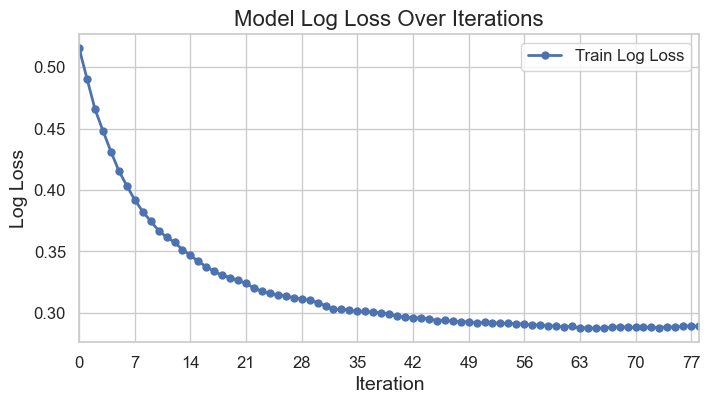

In [ ]:
# Apply the seaborn style to make plots nicer
sns.set(style="whitegrid")

# Create the figure with a specific size
plt.figure(figsize=(8, 4))

# Assuming you have the training history from your XGBoost model run
# Replace 'xgb_history' with the actual variable name that stores the training history
xgb_history = xgb_model.evals_result()

# Accuracy plot
plt.subplot(1, 1, 1)
plt.plot(xgb_history['validation_0']['logloss'], label='Train Log Loss', linewidth=2, marker='o', markersize=5)

# Title and labels
plt.title('Model Log Loss Over Iterations', fontsize=16)
plt.ylabel('Log Loss', fontsize=14)
plt.xlabel('Iteration', fontsize=14)

# Legend
plt.legend(loc='upper right', fontsize=12)

# Set limits and ticks for readability
plt.xlim(0, len(xgb_history['validation_0']['logloss']) - 1)
plt.xticks(range(0, len(xgb_history['validation_0']['logloss']), max(len(xgb_history['validation_0']['logloss']) // 10, 1)), fontsize=12)
plt.yticks(fontsize=12);

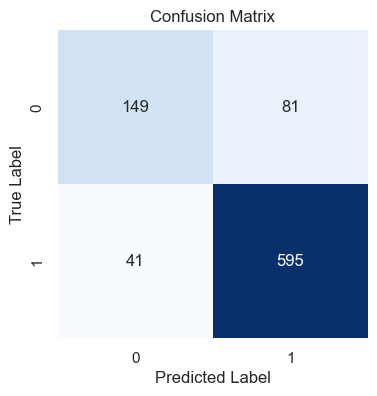

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

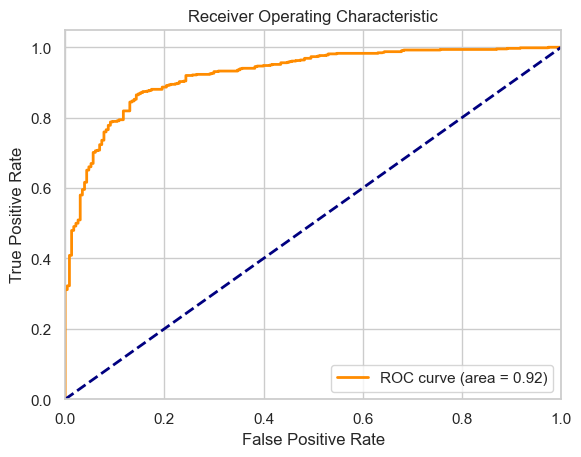

In [ ]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

In [ ]:
xgb_model.save_model(f"saved_models/XGBoost_model_Acc_{round(test_accuracy,3)}_F1_{round(f1,3)}.bin")